Fetching data from Wikimedia API...
Requesting URL: https://wikimedia.org/api/rest_v1/metrics/registered-users/new/en.wikipedia.org/monthly/20100121/20250117

Successfully retrieved data

Sample of the data:
                  timestamp  new_users
0 2010-02-01 00:00:00+00:00     185110
1 2010-03-01 00:00:00+00:00     191352
2 2010-04-01 00:00:00+00:00     169951
3 2010-05-01 00:00:00+00:00     168371
4 2010-06-01 00:00:00+00:00     134593
                   timestamp  new_users
54 2014-08-01 00:00:00+00:00     330290
62 2015-04-01 00:00:00+00:00     307409
56 2014-10-01 00:00:00+00:00     239640
55 2014-09-01 00:00:00+00:00     236425
61 2015-03-01 00:00:00+00:00     234509
57 2014-11-01 00:00:00+00:00     233741
59 2015-01-01 00:00:00+00:00     232473
60 2015-02-01 00:00:00+00:00     225650
58 2014-12-01 00:00:00+00:00     224295
63 2015-05-01 00:00:00+00:00     218417

Creating visualization...

Visualization saved as wikipedia_new_users.png


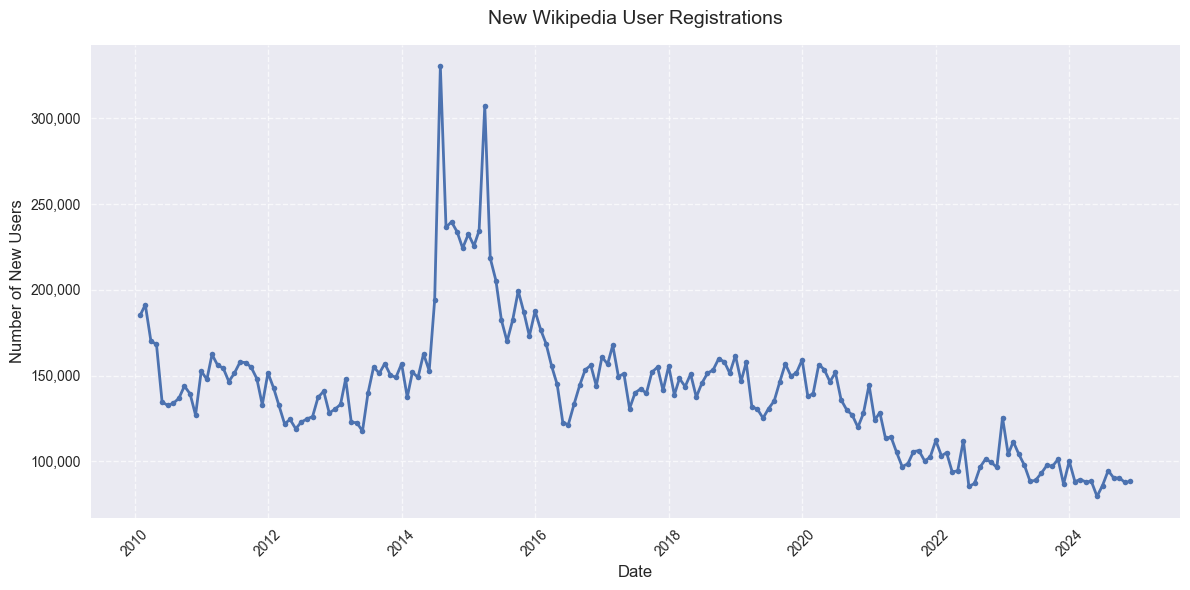


Statistics:
Total new users: 25,213,853
Average monthly new users: 140,860
Highest month: 2014-08 (330,290 users)


In [3]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

def get_new_users_rest_api(project='en.wikipedia.org', granularity='monthly', start=None, end=None):
    """
    Retrieve new user registration statistics using Wikimedia's REST API
    """
    if not end:
        end = datetime.now().strftime('%Y%m%d')
    if not start:
        start_date = datetime.now() - timedelta(days=365*15)
        start = start_date.strftime('%Y%m%d')
    
    base_url = "https://wikimedia.org/api/rest_v1/metrics/registered-users/new"
    url = f"{base_url}/{project}/{granularity}/{start}/{end}"
    
    print(f"Requesting URL: {url}")
    
    headers = {
        'User-Agent': 'NewUsersAnalytics/1.0',
        'Accept': 'application/json'
    }
    
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        
        if 'items' not in data or not data['items']:
            print("Error: No data returned from API")
            return None
        
        # Extract the results list from the first item
        results = data['items'][0]['results']
        
        # Create DataFrame from the results list
        df = pd.DataFrame(results)
        
        # Convert timestamp to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Rename column for clarity
        df = df.rename(columns={'new_registered_users': 'new_users'})
        
        return df
        
    except requests.exceptions.RequestException as e:
        print(f"Error accessing Wikimedia REST API: {e}")
        if hasattr(e, 'response') and e.response is not None:
            print(f"Response status code: {e.response.status_code}")
            print(f"Response content: {e.response.text}")
        return None

def plot_user_trends(df):
    """
    Create a visualization of user registration trends
    """
    # Set the style
    plt.style.use('seaborn-v0_8')  # Updated to use the correct style name
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create the line plot
    plt.plot(df['timestamp'], df['new_users'], 
            marker='o', markersize=4, linewidth=2)
    
    # Customize the plot
    plt.title('New Wikipedia User Registrations', fontsize=14, pad=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of New Users', fontsize=12)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Add thousand separator to y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

# Example usage
if __name__ == "__main__":
    # Get data for the last 15 years
    start_date = (datetime.now() - timedelta(days=365*15)).strftime('%Y%m%d')
    end_date = datetime.now().strftime('%Y%m%d')
    
    print("Fetching data from Wikimedia API...")
    df = get_new_users_rest_api(
        granularity='monthly',
        start=start_date,
        end=end_date
    )
    
    if df is not None:
        print("\nSuccessfully retrieved data")
        print("\nSample of the data:")
        print(df.head())

        print(df.nlargest(10, "new_users"))
        
        print("\nCreating visualization...")
        
        # Create and save the plot
        fig = plot_user_trends(df)
        output_file = 'wikipedia_new_users.png'
        fig.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"\nVisualization saved as {output_file}")
        
        # Show the plot
        plt.show()
        
        # Print some statistics
        print("\nStatistics:")
        print(f"Total new users: {df['new_users'].sum():,}")
        print(f"Average monthly new users: {df['new_users'].mean():,.0f}")
        print(f"Highest month: {df.loc[df['new_users'].idxmax(), 'timestamp'].strftime('%Y-%m')}"
              f" ({df['new_users'].max():,} users)")